# PVT - модель флюида в унифлок VBA

В Унифлок VBA реализована модель black oil для моделирования свойств нефти, газа и воды

In [1]:
"""
Импорт унифлока зависит от корректных путей к надстройке
Путь задается вручную в явном виде (так проще всего)
"""

unifloc_path = r'C:\unifloc\unifloc_vba'
unifloc_xlam = unifloc_path +r'\UniflocVBA_7.xlam'
print('Путь к надстройке Unifloc VBA -- '+ unifloc_xlam)

import sys
sys.path.insert(0, unifloc_path) # добавим в путь поиска пакетов python папку где находится репозиторий Unifloc VBA
import unifloc_vba_python_api.python_api as unifloc # импортируем python_api для Unifloc VBA

# создаем объект имеющий доступ к расчетам Unifloc VBA
unf = unifloc.API(unifloc_xlam)

print('объект unf обеспечивает доступ к API Unifloc VBA')

Путь к надстройке Unifloc VBA -- C:\unifloc\unifloc_vba\UniflocVBA_7.xlam
объект unf обеспечивает доступ к API Unifloc VBA


In [2]:
# импортируем дополнительные библиотеки 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# векторизуем нужные функции для удобства построения графиков

PVT_rs_m3m3 = np.vectorize(unf.PVT_rs_m3m3)
PVT_pb_atma = np.vectorize(unf.PVT_pb_atma)

# Задание PVT свойств

Свойства флюида в Унифлок VBA определяются следующими параметрами:
- $\gamma_{gas}$ - `gamma_gas` - удельная плотность газа по воздуху;
- $\gamma_{oil}$ - `gamma_oil` - удельная плотность нефти по воде;
- $\gamma_{wat}$ - `gamma_wat` - удельная плотность воды по воде;
- $r_{sb}$ - `rsb_m3m3`- газосодержание при давлении насыщения (в пласте), м$^3$/м$^3$.

Дополнительно можно задать калибровочные параметры, позволяющие настроить модель на данные замеров:
- $p_b$ - `pb_atma` - давление насыщения, атма;
- $t_{res}$ - `t_res_C` - пластовая температура или температура при которой определено давление насыщения, С;
- $b_{ob}$ - `bob_m3m3` - объемный коэффициент нефти при давлении насыщения и соответствующей температуре, м$^3$/м$^3$;
- $\mu_{ob}$ - `muo_cP` - вязкость нефти при давлении насыщения и соответствующей температуре, сП.

Также можно указать набор корреляций, которые будут использоваться для расчета. Реализованы два набора корреляций:
- `PVT_correlation = 0` набор корреляций на основе корреляций Стендинга;
- `PVT_correlation = 1` набор корреляций на основе корреляций Веларде Мак Кейна.

В унифлок VBA используется упрощенная схема калибровки свойств нефти на значения при давлении насыщения. В некоторых программных продуктах можно встретить более универсальные схемы калибровки, например по нескольким точкам. Реализованной схемы часто оказывается достаточно для практических расчетов.

Для работы с PVT свойствами использует объектная модель флюида как в программной реализации, так и на уровене пользовательских функций. В программной реализации расчет PVT свойств ведется классом `CPVT`. На уровне пользовательских функций свойства флюидов необходимые для проведения расчетов кодируются в json словать с использованием функции `encode_PVT`.

In [4]:
# задаем флюид в виде json словаря задавая все параметры.
# для наглядности используем имена аргументов для задания значений
fluid = unf.encode_PVT(gamma_gas=0.8, 
                       gamma_oil=0.82, 
                       gamma_wat=1.1, 
                       rsb_m3m3=120, 
                       pb_atma=150, 
                       t_res_C=80, 
                       bob_m3m3=1.2, 
                       muob_cP=0.5, 
                       PVT_corr_set=0)
# выведем итоговую json строку
print(fluid)

{"gamma_gas":0.8,"gamma_oil":0.82,"gamma_wat":1.1,"rsb_m3m3":120,"pb_atma":150,"t_res_C":80,"bob_m3m3":1.2,"muob_cP":0.5,"PVT_corr_set":0}


Закодированные в виде json строки свойства флюидов позволяют на основе корреляций рассчитать все необходимые для расчетов параметры флюидов при произвольных значениях давления и температуры. Пример кодирования: `{"gamma_gas":0.8,"gamma_oil":0.82,"gamma_wat":1.1,"rsb_m3m3":120,"pb_atma":150,"t_res_C":80,"bob_m3m3":1.2,"muob_cP":0.5,"PVT_corr_set":0}`.

Расчетные функции для свойств флюидов начинаются с префикса `PVT_`, например функция расчета газосодержания имеет название `PVT_rs_m3m3`. Для всех пользовательских функций возвращающих размерные значения, размерность указывается в явном виде в названии функции. Некоторые функции могут возвращать словари значений в виде json строк, тогда в названии функции размерности не указываются. В Python API названия функций совпадают с названиями унифлок VBA (генерируются автоматически).

In [5]:
# встроенная python функция help может помочь узнать, какие аргументы ожидают функции унифлок vba. 
help(unf.encode_PVT)

Help on method encode_PVT in module unifloc_vba_python_api.python_api:

encode_PVT(gamma_gas=0.6, gamma_oil=0.86, gamma_wat=1, rsb_m3m3=100, pb_atma=0, t_res_C=80, bob_m3m3=0, muob_cP=0, PVT_corr_set=0) method of unifloc_vba_python_api.python_api.API instance
    ========== description ==============
    Функция кодирования параметров PVT в строку,  для передачи PVT свойств в прикладные функции Унифлок.

    ==========  arguments  ==============

        gamma_gas - удельная плотность газа, по воздуху.  по умолчанию const_gg_ = 0.6

        gamma_oil - удельная плотность нефти, по воде.  по умолчанию const_go_ = 0.86

        gamma_wat - удельная плотность воды, по воде.  по умолчанию const_gw_ = 1

        rsb_m3m3 - газосодержание при давлении насыщения, м3/м3.  по умолчанию const_rsb_default = 100

        pb_atma - давление насыщения при заданной температуре, атма.  опциональный калибровочный параметр,  если не задан или = 0, то рассчитается по корреляции.

        t_res_c - пласто

# Зависимость давления насыщения от газосодержания при давлении насыщения

Базовая корреляция применяемая при расчетах позволяет оценить давление насыщения от количества растворенного в нефти газа - $p_b$ vs $r_{sb}$. При фиксированной температуре зависимость монотонная - чем больше газосодержание в нефти, тем больше давление насыщения.

In [6]:
# задаем минимальный набор свойств флюида с газосодержанием
fluid = unf.encode_PVT(gamma_gas=0.8, gamma_oil=0.82, gamma_wat=1.1, 
                       rsb_m3m3=120)
# выведем итоговую json строку
print(fluid)

# по заданному флюиду можно оценить давление насыщения
pb = unf.PVT_pb_atma(t_C = 80, PVT_prop = fluid)
print(f"Давление насыщения pb = {pb}")

{"gamma_gas":0.8,"gamma_oil":0.82,"gamma_wat":1.1,"rsb_m3m3":120,"PVT_corr_set":0}
Давление насыщения pb = 146.4261947356527


In [7]:
# аргументы функции расчета давления насыщения
help(unf.PVT_pb_atma)

Help on method PVT_pb_atma in module unifloc_vba_python_api.python_api:

PVT_pb_atma(t_C, PVT_prop='') method of unifloc_vba_python_api.python_api.API instance
    ========== description ==============
    Расчет давления насыщения по известному  газосодержанию при давлении насыщения

    ==========  arguments  ==============

        t_c - температура, с.

        pvt_prop - строка с параметрами флюида,  используйте encode_pvt для ее генерации,  если задана перекрывает остальные параметры



In [8]:
# функция расчета вектора значений давления насыщения по вектору значений газосодержания при давлении насыщения
def pb_arr(gg, go, rsb_arr, t_C=80, PVT_corr_set=0):
    fluid_arr = [unf.encode_PVT(gamma_gas=gg, gamma_oil=go, gamma_wat=1.1, 
                                rsb_m3m3=rsb, PVT_corr_set=PVT_corr_set) 
                 for rsb in rsb_arr]
    return PVT_pb_atma(t_C=t_C, PVT_prop = fluid_arr)   

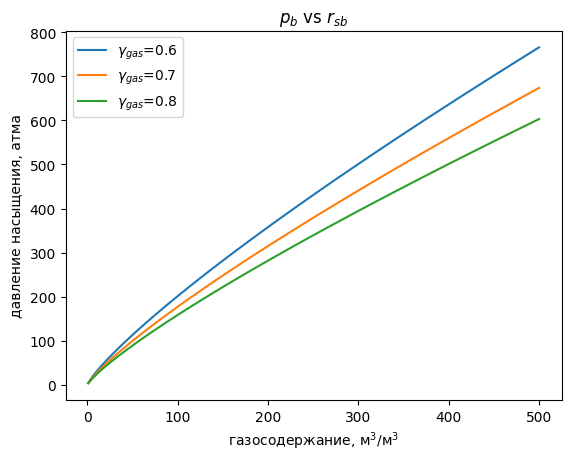

In [9]:
rsb_arr = np.linspace(1,500, 100)
plt.plot(rsb_arr, pb_arr(gg=0.6, go=0.86, rsb_arr=rsb_arr), label="$\\gamma_{gas}$=0.6")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr), label="$\\gamma_{gas}$=0.7")
plt.plot(rsb_arr, pb_arr(gg=0.8, go=0.86, rsb_arr=rsb_arr), label="$\\gamma_{gas}$=0.8")

plt.title("$p_b$ vs $r_{sb}$")
plt.xlabel("газосодержание, м$^3$/м$^3$")
plt.ylabel("давление насыщения, атма")
plt.legend()
plt.show() 

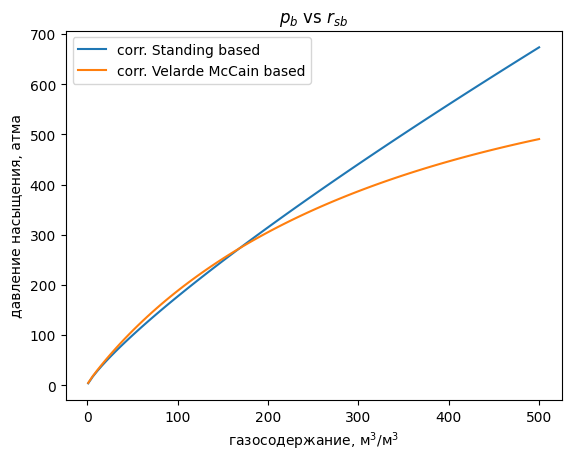

In [10]:
rsb_arr = np.linspace(1,500, 100)
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, PVT_corr_set=0), label = "corr. Standing based")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, PVT_corr_set=1), label = "corr. Velarde McCain based")

plt.title("$p_b$ vs $r_{sb}$")
plt.xlabel("газосодержание, м$^3$/м$^3$")
plt.ylabel("давление насыщения, атма")
plt.legend()
plt.show() 

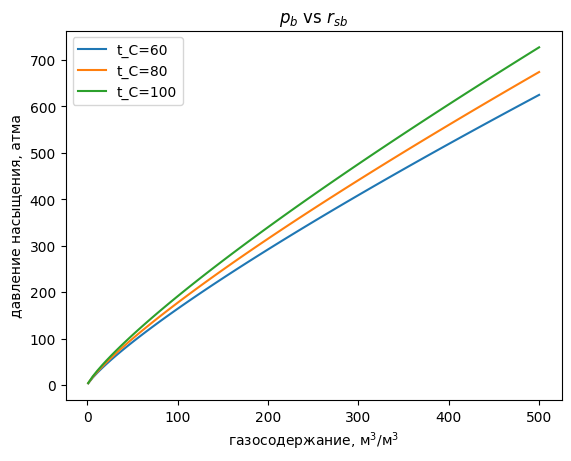

In [11]:
rsb_arr = np.linspace(1,500, 100)
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=60), label="t_C=60")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=80), label="t_C=80")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=100), label="t_C=100")

plt.title("$p_b$ vs $r_{sb}$")
plt.xlabel("газосодержание, м$^3$/м$^3$")
plt.ylabel("давление насыщения, атма")
plt.legend()
plt.show() 

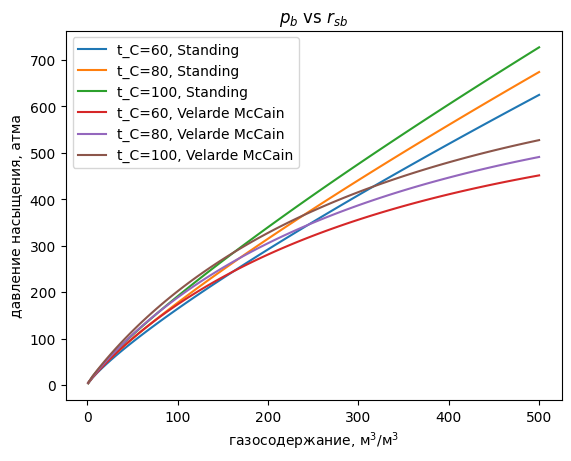

In [12]:
rsb_arr = np.linspace(1,500, 100)
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=60, PVT_corr_set=0), label="t_C=60, Standing")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=80, PVT_corr_set=0), label="t_C=80, Standing")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=100, PVT_corr_set=0), label="t_C=100, Standing")

plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=60, PVT_corr_set=1), label="t_C=60, Velarde McCain")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=80, PVT_corr_set=1), label="t_C=80, Velarde McCain")
plt.plot(rsb_arr, pb_arr(gg=0.7, go=0.86, rsb_arr=rsb_arr, t_C=100, PVT_corr_set=1), label="t_C=100, Velarde McCain")

plt.title("$p_b$ vs $r_{sb}$")
plt.xlabel("газосодержание, м$^3$/м$^3$")
plt.ylabel("давление насыщения, атма")
plt.legend()
plt.show() 

# Газосодержание при разгазировании

Чтобы проиллюстрировать важные различия между двумя наборами корреляций построим зависимости давления насыщения от газосодержания в пластовых условиях и зависимости газосодержания от давления при разгазировании на одном графике.

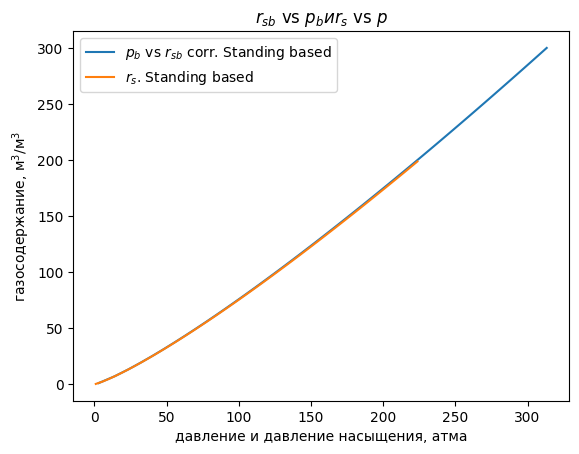

Для корреляции Стендинга кривая разгазирования является обратной к кривой зависимости давления насыщения от газосодержания


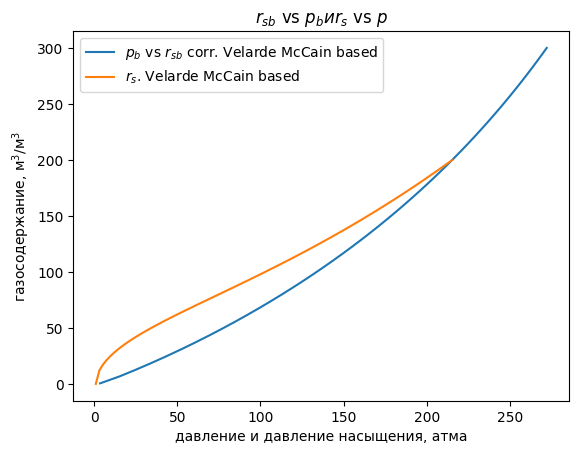

Для корреляции Веларде МакКейна кривая разгазирования отличается от кривой зависимостидавления насыщения от газосодержания, что более физично и учитывает различия растворимости разных компонент газаЧем больше плотность газа отличается от плотности метана, тем больше будет различие.


In [13]:
gg = 0.8
go = 0.82
gw = 1.1
tres = 80
# зададим значение газосодержания с которого будем рассчитывать разгазирование
rsb1 = 200
# зададим массив газосодержаний для графика зависимости давления насыщения от газосодержания
rsb_arr = np.linspace(1,300, 50)
# зададим флюид для разгазирования
fluid = unf.encode_PVT(gamma_gas=gg, gamma_oil=go, gamma_wat=gw, 
                       rsb_m3m3=rsb1, PVT_corr_set=0)
# оценим значение давления насыщения
pb1 = PVT_pb_atma(t_C = tres, PVT_prop = fluid)
# зададим массив давлений для графика газосодержания
parr = np.linspace(1, pb1, 50)

plt.plot(pb_arr(gg=gg, go=go, rsb_arr=rsb_arr, PVT_corr_set=0), rsb_arr, label = "$p_b$ vs $r_{sb}$ corr. Standing based")
plt.plot(parr, PVT_rs_m3m3(parr, tres, fluid), label = "$r_s$. Standing based")

plt.title("$r_{sb}$ vs $p_{b} и r_{s}$ vs $p$")
plt.xlabel("давление и давление насыщения, атма")
plt.ylabel("газосодержание, м$^3$/м$^3$")
plt.legend()
plt.show() 

print("Для корреляции Стендинга кривая разгазирования является обратной к кривой зависимости давления насыщения от газосодержания")

# зададим флюид для разгазирования
fluid = unf.encode_PVT(gamma_gas=gg, gamma_oil=go, gamma_wat=gw, 
                       rsb_m3m3=rsb1, PVT_corr_set=1)
# оценим значение давления насыщения
pb1 = PVT_pb_atma(t_C = tres, PVT_prop = fluid)
# зададим массив давлений для графика газосодержания
parr = np.linspace(1, pb1, 100)

plt.plot(pb_arr(gg=gg, go=go, rsb_arr=rsb_arr, PVT_corr_set=1), rsb_arr, label = "$p_b$ vs $r_{sb}$ corr. Velarde McCain based")
plt.plot(parr, PVT_rs_m3m3(parr, tres, fluid), label = "$r_s$. Velarde McCain based")

plt.title("$r_{sb}$ vs $p_{b} и r_{s}$ vs $p$")
plt.xlabel("давление и давление насыщения, атма")
plt.ylabel("газосодержание, м$^3$/м$^3$")
plt.legend()
plt.show() 

print("Для корреляции Веларде МакКейна кривая разгазирования отличается от кривой зависимости" + 
"давления насыщения от газосодержания, что более физично и учитывает различия растворимости разных компонент газа" + 
"Чем больше плотность газа отличается от плотности метана, тем больше будет различие.")

## Базовые зависимости от давления и температуры

In [37]:
gg = 0.8
go = 0.86
gw = 1.1
rsb = 120
PVT_corr_set = 0
plist = np.linspace(1, 250, 100)

# задаем флюид задавая все параметры.
# для наглядности используем имена аргументов для задания значений
fluid = unf.encode_PVT(gamma_gas=gg, 
                       gamma_oil=go, 
                       gamma_wat=gw, 
                       rsb_m3m3=rsb)
# выведем итоговую json строку
print(fluid)

{"gamma_gas":0.8,"gamma_oil":0.86,"gamma_wat":1.1,"rsb_m3m3":120,"PVT_corr_set":0}


In [59]:
# опишем функцию для отрисовки группы графиков

def plot_pvt(func = PVT_rs_m3m3, pb_atma = -1, t_res_C=80, PVT_corr_set=0):
    fluid = unf.encode_PVT(gamma_gas=gg, gamma_oil=go, gamma_wat=gw,  pb_atma=120, t_res_C = 80, 
                       rsb_m3m3=rsb)
    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    axs[0,0].plot(plist, func(p_atma=plist, t_C=40, PVT_prop=fluid), label = "t = 40 °C" )
    axs[0,0].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid), label = "t = 80 °C"  )
    axs[0,0].plot(plist, func(p_atma=plist, t_C=120, PVT_prop=fluid), label = "t = 120 °C"  )
    axs[0,0].set_xlabel('давление, атма')
    axs[0,0].set_ylabel('газосодержание, м$^3$/м$^3$')
    axs[0,0].legend()
    
    rsb_arr = [80, 100, 120]
    fluid_arr = [unf.encode_PVT(gamma_gas=gg, gamma_oil=go, gamma_wat=gw, pb_atma=120, t_res_C = 80, 
                                rsb_m3m3=rsb_, PVT_corr_set=PVT_corr_set) 
                 for rsb_ in rsb_arr]
    
    axs[0,1].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[0]), label = "$r_{sb}$ = 80 м$^3$/м$^3$" )
    axs[0,1].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[1]), label = "$r_{sb}$ = 100 м$^3$/м$^3$"  )
    axs[0,1].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[2]), label = "$r_{sb}$ = 120 м$^3$/м$^3$"  )
    axs[0,1].set_xlabel('давление, атма')
    axs[0,1].set_ylabel('газосодержание, м$^3$/м$^3$')
    axs[0,1].legend()
    
    
    
    go_arr = [0.82, 0.85, 0.88]
    fluid_arr = [unf.encode_PVT(gamma_gas=gg, gamma_oil=go_, gamma_wat=gw, pb_atma=120, t_res_C = 80,
                                rsb_m3m3=rsb, PVT_corr_set=PVT_corr_set) 
                 for go_ in go_arr]
    
    axs[1,0].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[0]), label = f"$\\gamma_{{oil}}$ = {go_arr[0]}" )
    axs[1,0].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[1]), label = f"$\\gamma_{{oil}}$ = {go_arr[1]}"  )
    axs[1,0].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[2]), label = f"$\\gamma_{{oil}}$ = {go_arr[2]}"  )
    axs[1,0].set_xlabel('давление, атма')
    axs[1,0].set_ylabel('газосодержание, м$^3$/м$^3$')
    axs[1,0].legend()
    
    gg_arr = [0.6, 0.7, 0.8]
    fluid_arr = [unf.encode_PVT(gamma_gas=gg_, gamma_oil=go, gamma_wat=gw, pb_atma=120, t_res_C = 80,
                                rsb_m3m3=rsb, PVT_corr_set=PVT_corr_set) 
                 for gg_ in gg_arr]
    
    axs[1,1].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[0]), label = f"$\\gamma_{{gas}}$ = {gg_arr[0]}" )
    axs[1,1].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[1]), label = f"$\\gamma_{{gas}}$ = {gg_arr[1]}"  )
    axs[1,1].plot(plist, func(p_atma=plist, t_C=80, PVT_prop=fluid_arr[2]), label = f"$\\gamma_{{gas}}$ = {gg_arr[2]}"  )
    axs[1,1].set_xlabel('давление, атма')
    axs[1,1].set_ylabel('газосодержание, м$^3$/м$^3$')
    axs[1,1].legend()
    
    plt.show()

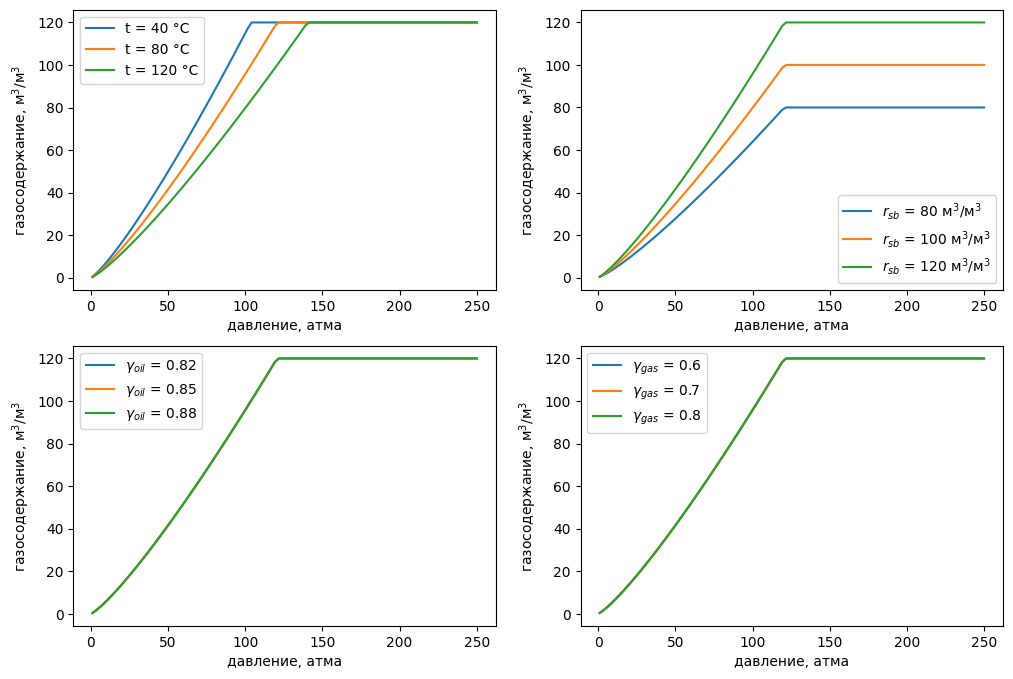

In [60]:
plot_pvt()

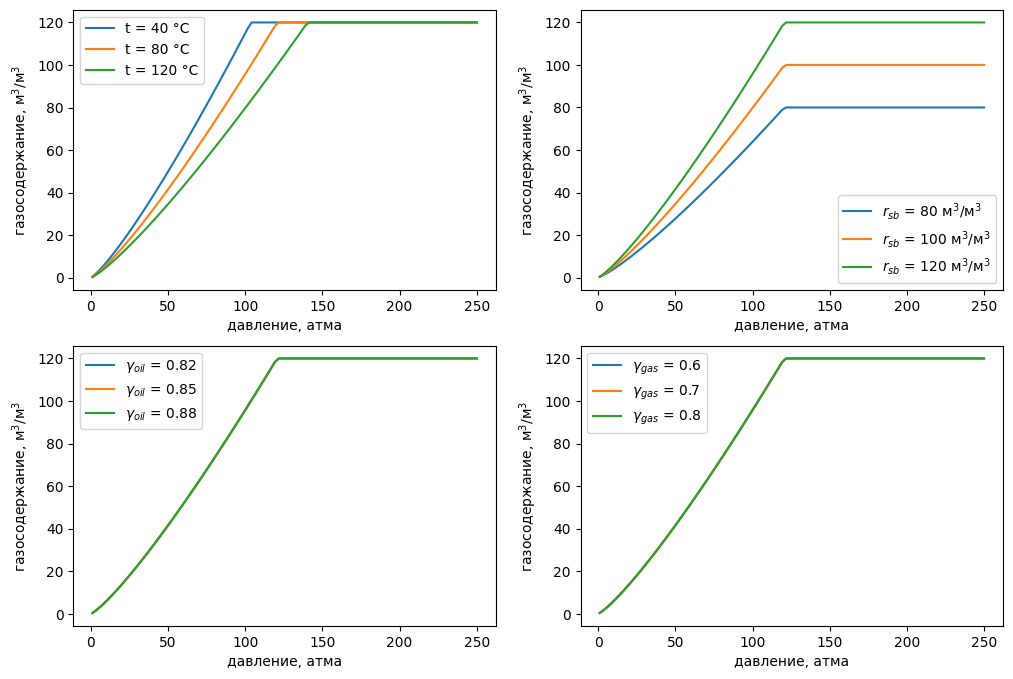

In [62]:
plot_pvt(PVT_corr_set=0, pb_atma=120)

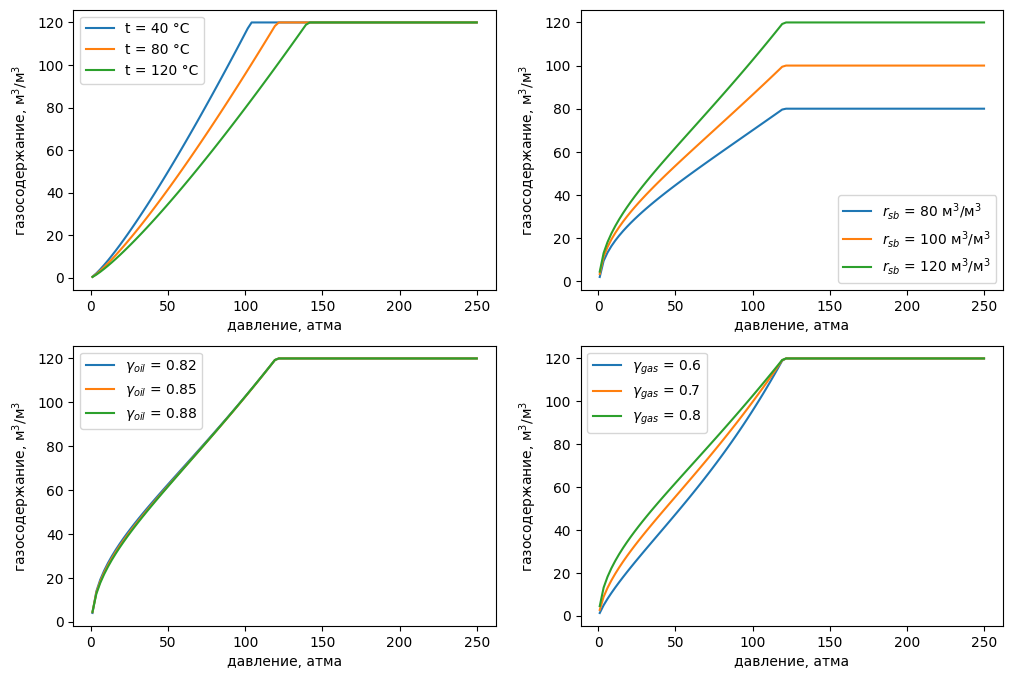

In [63]:
plot_pvt(PVT_corr_set=1, pb_atma=120)